In [1]:
import pandas as pd
import torch, torchdata, torchtext
from torch import nn
import time
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 2422
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
torch.__version__

'1.13.1+cu117'

In [3]:
torchtext.__version__

'0.14.1'

## Load the given dataset

1. Create a variable to your dataset PATH *example:  ./data/*
2. Load the csv files using pandas 



In [4]:
#if you are using puffer
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# DATA_PATH = ""

train_data_raw = pd.read_csv('dataset/train.csv')
test_data_raw = pd.read_csv('dataset/test.csv')

In [5]:
train_data_raw.shape

(7613, 5)

In [6]:
test_data_raw.shape

(3263, 4)

In [7]:
## Lets analyze the data a little

#print and show how many unique classes are in the target

classes = train_data_raw.target.value_counts() #Sentiment analysis only 0 or 1
num_classes = len(classes)
num_classes

2

In [8]:
assert num_classes > 1

In [9]:
##lets see how many columns are there
#print the columns of the train_data_raw

print(train_data_raw.columns) #write your code here

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


In [10]:
train_data_raw['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

1. Lets remove the keywords and location columns. We only want to focus on the text and the predictions
2. Lets split some training data to validation dataset

In [11]:
SPLIT_PER = 2 #percentage of split for validation set 2 = 2%
split =  int(len(train_data_raw) * (SPLIT_PER/100))

dropped_train = train_data_raw.drop(columns=['id', 'keyword', 'location']) #drop the id, keyowrd and location columns from the train_data_raw

train_data = dropped_train[:-split]
valid_data = dropped_train[-split:]
assert train_data.shape == (len(train_data_raw) - split, 2)
assert valid_data.shape == (split, 2)

In [12]:
print(train_data_raw.shape)
print("After dropping columns and spliting!")
print(train_data.shape, valid_data.shape)

(7613, 5)
After dropping columns and spliting!
(7461, 2) (152, 2)


## Lets tokenize the data

In [13]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy',language='en_core_web_sm')
 
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

In [14]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):
    for text, _ in data_iter.itertuples(index=False):
        yield tokenizer(text)
    #loop through the data_iter, 
    # Mind that the data_iter in this case is pandas Dataframe
    # pass #remove this line and code here

specials = ['<unk>','<pad>','<bos>','<eos>'] #create array of special tags for the vocab
vocab  = build_vocab_from_iterator(yield_tokens(train_data), specials = specials, special_first=True)

#set_default_index of the vocab to unknown tag
vocab.set_default_index(vocab["<unk>"]) #if you don't the id of this word, set it unk

In [15]:
assert len(vocab) == 26442

In [16]:
vocab_dict = vocab.get_stoi()
vocab_dict

{'åÊI': 26441,
 'åÈMGN': 26439,
 "å¬'Only": 26438,
 'å£300': 26434,
 'å£150': 26432,
 'Ìü': 26430,
 'ÌÑ1': 26429,
 'Ì¢': 26427,
 '¡': 26426,
 '\x89âÂ': 26424,
 '\x89Û÷vulnerable\x89Ûª': 26423,
 '\x89Û÷nuclear': 26421,
 '\x89Û÷minimum': 26419,
 '\x89Û÷hoax': 26416,
 '\x89Û÷hazard\x89Ûª': 26415,
 '\x89Û÷em': 26411,
 '\x89Û÷We': 26408,
 '\x89Û÷The': 26407,
 '\x89Û÷Muslim': 26405,
 '\x89Û÷amino': 26409,
 '\x89Û÷Islamic': 26402,
 '\x89Û÷Institute': 26401,
 '\x89Û÷Hijacker': 26400,
 '\x89Û÷Heat': 26399,
 '\x89Û÷Faceless\x89Ûª': 26398,
 '\x89Û÷Devastated\x89Ûª': 26396,
 '\x89Û÷Bomb': 26394,
 '\x89Û÷Avalanche\x89Ûª': 26392,
 '\x89ÛÒThe': 26387,
 '\x89ÛÏsippin\x89Ûª': 26386,
 '\x89ÛÏplans': 26385,
 '\x89ÛÏThat\x89Ûªs': 26383,
 '\x89ÛÏLittle': 26378,
 '\x89ÛÏI': 26377,
 '\x89ÛÏDetonate\x89Û\x9d': 26375,
 '\x89ÛÏAfter': 26371,
 '\x89ÛÏ@YMcglaun': 26366,
 '\x89ÛÏ@SplottDave': 26364,
 '\x89ÛÏ@MacDaddy_Leo': 26363,
 '\x89ÛÏ@LeoBlakeCarter': 26361,
 '\x89ÛÏ@LeeJasper': 26360,
 '\x89ÛÏ@BBCWomansHour':

In [17]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') ##Load fasttext with language=simple

In [18]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

#since the fasttext  has 300 embedding
assert fast_embedding.shape == (len(vocab), 300)

In [19]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) # 0,1 ## Copy from the lab. Note that Something has to be changed

In [20]:
text_pipeline("I love to play football")

[13, 185, 10, 683, 2229]

In [21]:
label_pipeline('1')

1

## To fit the padnas dataframe to DataLoader first we must wrap it as DataSet

In [22]:

from torch.utils.data import Dataset

class PD_DATASET(Dataset):

    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]

In [23]:
train = PD_DATASET(train_data)
valid = PD_DATASET(valid_data)
test = PD_DATASET(test_data_raw)

In [24]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] ##get the pad index from the vocab

def collate_batch(batch):
    ## copy the collate_batch function from Professor's code. But it will not work right away
    #mind how the dataset that we use is structured (hint: columns)
    label_list, text_list = [], []
    for (_text, _label) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True)

In [25]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)

In [26]:
next(iter(train_loader))

(tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
         0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]),
 tensor([[  927,  1891,   298,  ...,     1,     1,     1],
         [ 1606,   480,  1373,  ...,     1,     1,     1],
         [    4, 11448,  7141,  ...,     1,     1,     1],
         ...,
         [  106, 17820, 17901,  ...,     1,     1,     1],
         [    4, 25073,  1078,  ...,     1,     1,     1],
         [   45, 25530,  1442,  ...,     1,     1,     1]]))

In [27]:
for label, text in train_loader:
    break

In [28]:
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 36])


## First lets try CNN

In [29]:
import torch.nn as nn
import torch.nn.functional as F

## Get the Professor's code from  the lab to build the CNN model

class CNN(nn.Module):
    # pass #replace this line with the respected code
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters,filter_sizes):

        #filter_sizes = [3,4,5]
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.conv = nn.ModuleList([
                        nn.Conv1d(
                            in_channels  = emb_dim,
                            out_channels = n_filters, #100
                            kernel_size  = fs #n-grams
                            )
                        for fs in filter_sizes
                    ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(n_filters * len(filter_sizes), output_dim)

    def forward(self, text): 
        #text : [batch_size, seq_len]

        #embed the text
        embedded = self.embedding(text)
        #embedded : [batch_size, seq_len, emb_dim]
        #reshape embedded into [batch_size, emb_dim, seq_len] for CNN1d
        embedded = embedded.permute(0,2,1)
        #embedded : [batch_size, emb_dim, seq_len]

        conv_fea = [F.relu(conv(embedded)) for conv in self.conv]
        #conv_fea : [batch_size, emb_dim, seq_len]

        conv_fea_max = [F.max_pool1d(each_conv_fea, each_conv_fea.shape[2]).squeeze(2) for each_conv_fea in conv_fea]
        #pooled_n = [batch size, n_filters]

        #2. concat all three features into one
        #3. dropout
        final_conv_max = self.dropout(torch.cat(conv_fea_max, dim=1))
        #final_conv_max : [batch_size, out_channels * n_filters]

        return self.fc(final_conv_max)

In [30]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) 

In [31]:
input_dim  = len(vocab)
emb_dim    =  300 #how many embedding does the fasttext have 
output_dim =  2 #how many classes do we have
dropout    = 0.5
n_filters  = 100 
filter_sizes = [3, 4, 5]

cnn_model = CNN(input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes).to(device)
cnn_model.apply(initialize_weights)
cnn_model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [32]:
batch_size = 3
seq_len    = 50

In [33]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.SGD(cnn_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [34]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [35]:
def train(model, loader, optimizer, criterion, loader_length):
    #write the code to train the model
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
        
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1

        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [36]:
def evaluate(model, loader, criterion, loader_length):
    #write the code to evaluate 
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [38]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
train_loader_length, val_loader_length

(117, 3)

In [39]:
best_valid_loss = float('inf')
num_epochs      = 5

save_path = f'./models/{cnn_model.__class__.__name__}_ST.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    #write the code that starts the training, store the training and valid losses and accuracy
    #also print the time it took to train the model
    start_time = time.time()

    train_loss, train_acc = train(cnn_model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(cnn_model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(cnn_model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 4s
	Train Loss: 0.697 | Train Acc: 53.51%
	 Val. Loss: 0.683 |  Val. Acc: 49.31%
Epoch: 02 | Time: 0m 2s
	Train Loss: 0.682 | Train Acc: 56.70%
	 Val. Loss: 0.677 |  Val. Acc: 48.44%
Epoch: 03 | Time: 0m 2s
	Train Loss: 0.678 | Train Acc: 57.98%
	 Val. Loss: 0.675 |  Val. Acc: 48.44%
Epoch: 04 | Time: 0m 2s
	Train Loss: 0.668 | Train Acc: 59.41%
	 Val. Loss: 0.664 |  Val. Acc: 51.39%
Epoch: 05 | Time: 0m 2s
	Train Loss: 0.661 | Train Acc: 60.97%
	 Val. Loss: 0.660 |  Val. Acc: 50.52%


Text(0, 0.5, 'loss')

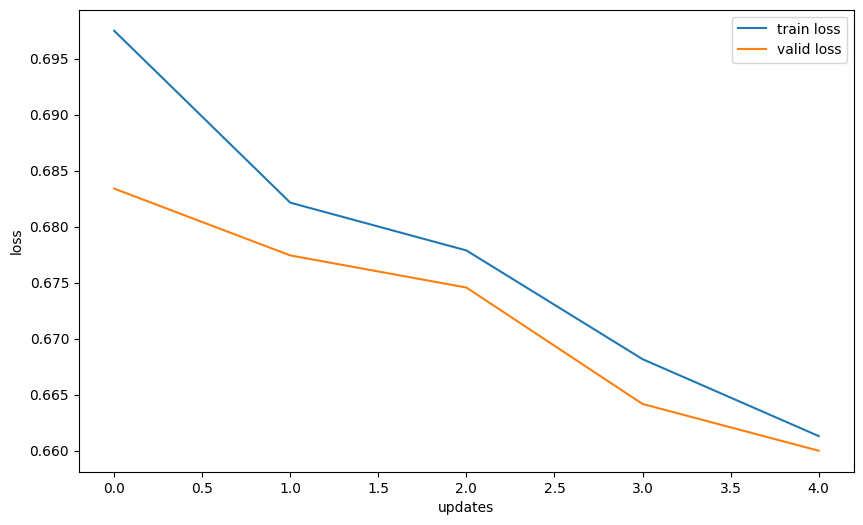

In [40]:
##Plot the training loss and the accuracy
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

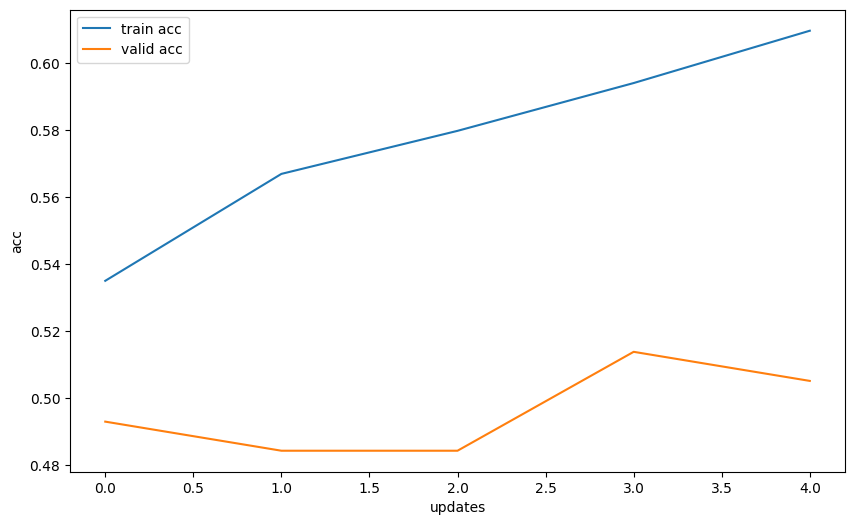

In [41]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

# Lets Try the LSTM model

In [42]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #mkaing each batch batch same length

pad_ix = vocab['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [],[],[]
    for (_text,_label,) in batch:
        label_list.append(label_pipeline(_label)) # (3, 1, 0, 2, 1)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) #(0, 44, 25, 1)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
    return torch.tensor(label_list,dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_ix,batch_first=True), \
        torch.tensor(length_list,dtype=torch.int64)

In [43]:
train = PD_DATASET(train_data)
valid = PD_DATASET(valid_data)
# test = PD_DATASET(test_data_raw)

In [44]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)

In [47]:
import torch.nn as nn

class LSTM(nn.Module):
    # pass #replace this line with the real code
    def __init__(self,input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #input dim = how many vocab you have
        #emb dim = 300 --> we use fasttext
        #padding_idx tells this lookup to ignore and just randomize....
        #<unk>, <bos>, <eos>
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, 
                            hid_dim, 
                            num_layers = num_layers, 
                            bidirectional = bidirectional, 
                            dropout = dropout, #dropout is applied between layers
                            batch_first = True) 
        self.fc = nn.Linear(hid_dim*2, output_dim)
    def forward(self, x, lengths):

        #x : [batch size, seq len]
        embedded_x = self.embedding(x)
        #x : [batch size, seq len, emb dim]

        #pack this embedded_x in such a way that RNN knows to ignore padding....
        #without batch first = True; thing will become [seq len, batch size, emb size]
        pack_embedded = nn.utils.rnn.pack_padded_sequence(embedded_x, 
                                                            lengths.to('cpu'),
                                                            enforce_sorted=False,
                                                            batch_first=True)
        #packed_output is basically all hidden states ==> POS tagging, NER

        #h is the last hidden state => sentiment analysis
        #c is the last cell state
        packed_output, (h,c) = self.lstm(pack_embedded)

        #h : [num_layers * num_directions, batch_size, hidden dim] 

        #it happen that because packed_ouputs is all hidden states... some hidden state near the end is
        #hidden state for padding, pytorch guys help you
        #by using this pack_padded_sequence, them all the hiddden states will only be not padding
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output,batch_first=True)

        #last hidden state - concat forward and backward states
        last_hidden_state = torch.cat((h[-1,:,:], h[-2,:,:]), dim = 1)
        #last_hidden_state: [batch_size, hidden_dim * 2]

        #for sentiment analysis... what whould i sent to my linear layer.....
        return self.fc(last_hidden_state) #[batch_size, output_dim] ==> [batch_size,4]

In [48]:
input_dim  = len(vocab)
emb_dim    = 300 #same as above
hidden_dim = 256 #how many hidden dims do you want?
output_dim = 2#same as above
dropout    = 0.5
num_layers = 2
bidirectional = True 

lstm_model = LSTM(input_dim, emb_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout).to(device)
lstm_model.apply(initialize_weights)
lstm_model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [49]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(lstm_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #

In [50]:
def train(model, loader, optimizer, criterion, loader_length):
    #write the code to train the model 
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [51]:
def evaluate(model, loader, criterion, loader_length):
    #write the code to evaluate the model
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [52]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
train_loader_length,val_loader_length

(117, 3)

In [53]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [54]:
best_valid_loss = float('inf')
num_epochs   = 5

save_path = f'./models/{lstm_model.__class__.__name__}_ST.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    #write the code that starts the training, store the training and valid losses and accuracy
    #also print the time it took to train the model
    start_time = time.time()

    train_loss, train_acc = train(lstm_model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(lstm_model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lstm_model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 4s
	Train Loss: 0.511 | Train Acc: 75.46%
	 Val. Loss: 0.324 |  Val. Acc: 90.28%
Epoch: 02 | Time: 0m 4s
	Train Loss: 0.290 | Train Acc: 88.51%
	 Val. Loss: 0.242 |  Val. Acc: 89.06%
Epoch: 03 | Time: 0m 5s
	Train Loss: 0.114 | Train Acc: 95.79%
	 Val. Loss: 0.378 |  Val. Acc: 83.68%
Epoch: 04 | Time: 0m 5s
	Train Loss: 0.048 | Train Acc: 98.70%
	 Val. Loss: 0.333 |  Val. Acc: 86.98%
Epoch: 05 | Time: 0m 5s
	Train Loss: 0.029 | Train Acc: 99.11%
	 Val. Loss: 0.438 |  Val. Acc: 85.07%


Text(0, 0.5, 'loss')

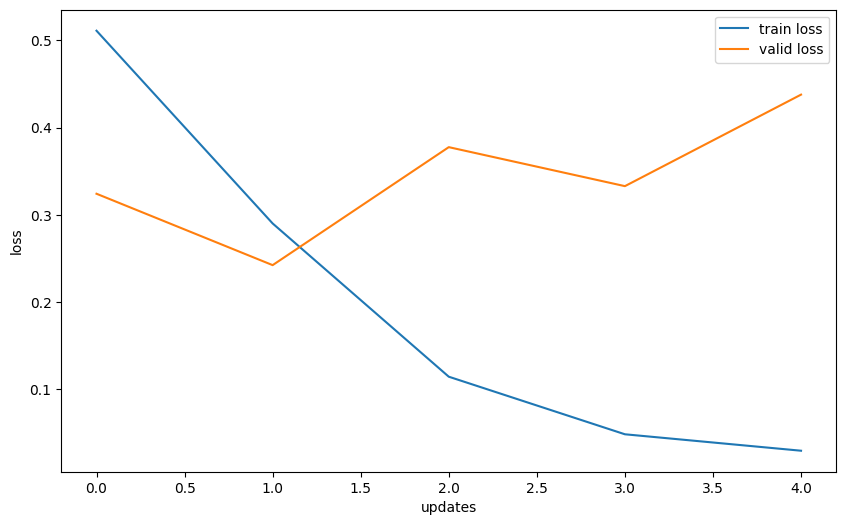

In [55]:
##Plot the losses and accuracy over all epochs
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

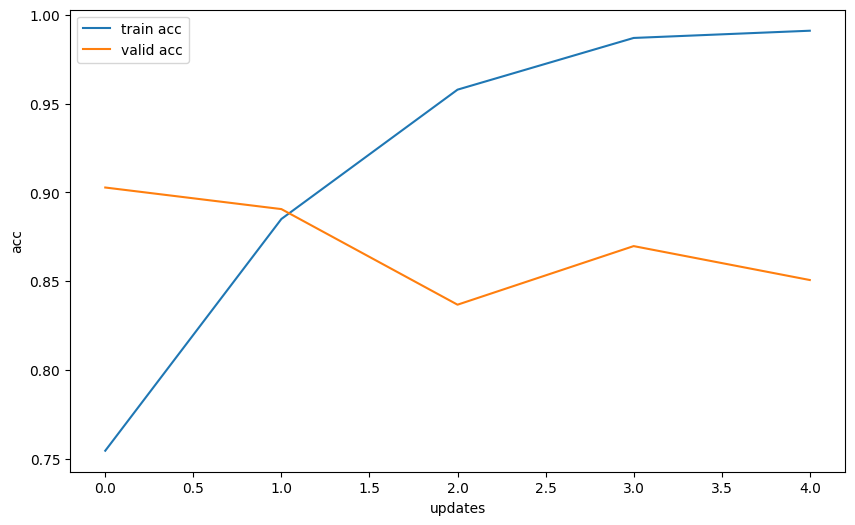

In [56]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

## Conclusion
- Compare the two models on their time and accuracy. Which one do you think did well for the disaster classification task.
- How do you think we get better results in this dataset for classification.

#### Write your answer here
- Compare the two models on their time and accuracy. Which one do you think did well for the disaster classification task.
    - It's obvious that using LSTM given a higher accuracy than CNN even I don't add FastText embedding.
    - Computational time is not slightly different.
- How do you think we get better results in this dataset for classification.
    - In dataset, some text provide some special character such as @nameuser which may better if we remove user name.